Overall solution description. Work done by Thomas DANIEL  

<span style="color:red">My EightPuzzle class and the search algorithms are highely inspired by the code found in the differents notebooks and LABS in the AI algorithm course 
from Farah AIT SALAHT.


PROBLEM FORMULATION: 

Question A. All others questions are either discussed within the code or answered at the end of the notebook

We are given a 3x3 grid with numbers ranging from 1 to 8 with one blank space. Each tiles can switch place with the blank space. The blank space as at most 4 possibilities : up,down,right,left. 

States: The different disposition of the grid.

Possibles actions: movements available for the blank space (up,down,right,left depending on the position)

Initial state: grid state at the beginning

Goal State: grid ordered correctly as follows : [[0,1,2],[3,4,5],[6,7,8]]. Here the blank is replaced by a 0. 

Important librairies: 

-heapq

-time

-random

-statistics

In [1]:
import heapq
""" Heapq will allow us to build our search algorithms. It provides priority queues which are widely used in search algorithm to find the next node to 
explore based on the total cost (f+g in the case of A*)"""

import time
"""The time library will allow us to get the compute time of our algorithms to make benchmarks and compare them."""

import random

"""The random module will help us build random initial states to conduct benchmarks."""

from statistics import mean

"""this module will be useful for the benchmarks"""


'this module will be useful for the benchmarks'

EigthPuzzle Class : Here is the code of my EightPuzzle Class. I will go through the designs choice steps just after. 

In [2]:
class EightPuzzle:

    def __init__(self, initial_state, goal_state):
        """Class constructor. We take as arguments the initial state and goal state.
        I choose to convert the 3x3 matrix into a tuple to be able to use sets in my search algorithms implementation. 
        I also choose to store the size of the grid to make it easier for some function implementations. 
        """
        self.initial_state = tuple(map(tuple, initial_state)) #Convert the 3x3 matrix list into a tuple
        self.goal_state = tuple(map(tuple, goal_state))#Convert the 3x3 matrix list into a tuple
        self.size = 3 #size of the matrix

    def get_blank_position(self, state):
        """Function to get the blank position in the grid that is represented by a 0.
           I choose to build the function to be able to get the position rapidly. 
        """
        for i in range(self.size):
            for j in range(self.size):
                if state[i][j] == 0: 
                    return i, j

    def get_neighbors(self, state):
        """Generate all possible neighboring states by moving the blank tile in one of the four possible directions
        (up, down, left, right), ensuring moves stay within bounds of the puzzle."""

        i, j = self.get_blank_position(state)  # Get the blank tile's position
        neighbors = []
        # Define possible moves for the blank tile: (row offset, column offset)
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Up, down, left, right
            new_i, new_j = i + di, j + dj
            if 0 <= new_i < self.size and 0 <= new_j < self.size:  # Ensure the new position is within bounds
                new_state = [list(row) for row in state]  # Create a copy of the current state as a list of lists
                # Swap the blank tile with the neighboring tile
                new_state[i][j], new_state[new_i][new_j] = new_state[new_i][new_j], new_state[i][j]
                neighbors.append(tuple(map(tuple, new_state)))  # Convert to tuple and add to neighbors
        return neighbors

    def is_goal(self, state):
        """Check if the current state matches the goal state.
        This function is used to determine if a solution has been found."""
        return state == self.goal_state

    def h1_misplaced_tiles(self, state):
        """Heuristic 1: Misplaced tiles. First heuristic implementation asked in the subject.
        We just check if the tile is different from the tile goal state and from 0. """
        return sum(1 for i in range(self.size) for j in range(self.size) if state[i][j] != self.goal_state[i][j] and state[i][j] != 0)

    def h2_manhattan_distance(self, state):
        """Heuristic 2: Manhattan distance. This heuristic calculates the sum of the Manhattan distances between each tile's current position
        and its goal position. Manhattan distance is the total number of vertical and horizontal moves
        needed to reach the goal position."""
        distance = 0
        goal = self.goal_state
        for i in range(self.size):
            for j in range(self.size):
                # Skip the blank tile
                if state[i][j] == 0:
                    continue
                # Find the current tile's value
                tile_value = state[i][j]
                # Find the target position of the tile in the goal state
                target_position = [(index, row.index(tile_value)) for index, row in enumerate(goal) if tile_value in row]
                # Since tile_value will be unique in a valid puzzle, we can safely get the first match
                if target_position:
                    target_row, target_col = target_position[0]  
                    # Calculate Manhattan distance
                    distance += abs(i - target_row) + abs(j - target_col)
        return distance
    
    def h3_row_column_mismatch(self, state):
        """Heuristic 3: Number of tiles not in the correct row + number of tiles not in the correct column"""
        row_mismatch = 0
        column_mismatch = 0
        goal = self.goal_state

        for i in range(self.size):
            for j in range(self.size):
                # Find the current tile's value
                tile_value = state[i][j]
                # Find the target position of the tile in the goal state
                target_position = [(index, row.index(tile_value)) for index, row in enumerate(goal) if tile_value in row]
                if target_position:
                    goal_i, goal_j = target_position[0]
                    # Check if the tile is in the correct row
                    if i != goal_i:
                        row_mismatch += 1
                    # Check if the tile is in the correct column
                    if j != goal_j:
                        column_mismatch += 1

        return row_mismatch + column_mismatch  # Return the total number of mismatches

    
    def h4_linear_conflict(self, state):
        """Heuristic 4: Linear Conflict. This heuristic adds penalties for pairs of tiles that are in the correct row or column 
        but in the wrong order, in addition to their Manhattan distances. Each conflicting pair contributes an additional 2 moves."""
        
        manhattan_distance = self.h2_manhattan_distance(state)
        linear_conflict = 0

        # Check for row conflicts
        for i in range(self.size):
            goal_positions = [divmod(state[i][j] - 1, self.size)[1] for j in range(self.size) if state[i][j] != 0 and divmod(state[i][j] - 1, self.size)[0] == i]
            for j in range(len(goal_positions)):
                for k in range(j + 1, len(goal_positions)):
                    if goal_positions[j] > goal_positions[k]:  # Conflict detected
                        linear_conflict += 2

        # Check for column conflicts
        for j in range(self.size):
            goal_positions = [divmod(state[i][j] - 1, self.size)[0] for i in range(self.size) if state[i][j] != 0 and divmod(state[i][j] - 1, self.size)[1] == j]
            for i in range(len(goal_positions)):
                for k in range(i + 1, len(goal_positions)):
                    if goal_positions[i] > goal_positions[k]:  # Conflict detected
                        linear_conflict += 2

        return manhattan_distance + linear_conflict

    def uniform_cost_search(self):
        """Uniform Cost Search (UCS) with node expansion tracking. UCS is a search algorithm that expands the node with the lowest cost first.
        It treats every move with a uniform cost (1 in this case) and is guaranteed to find the optimal solution."""
        start_node = (self.initial_state, [], 0)  # (state, path, cost): initial state, empty path, and zero cost
        frontier = [(0, start_node)]  # Priority queue (min-heap) where elements are prioritized by cost
        explored = set()  # Set to track explored states
        expanded_order = []  # List to track the order of node expansions

        while frontier:
            _, (state, path, cost) = heapq.heappop(frontier)  # Get the node with the lowest cost
            expanded_order.append(state)  # Record the expansion of this node

            if self.is_goal(state):  # If goal is reached, return the solution path and expansion order
                return path, expanded_order

            if state not in explored:  # Only expand the node if it hasn't been explored yet
                explored.add(state)

                # Expand all neighbors of the current state
                for neighbor in self.get_neighbors(state):
                    if neighbor not in explored:
                        new_path = path + [neighbor]  # Update path with the neighbor
                        new_cost = cost + 1  # Each move has a uniform cost of 1
                        new_node = (neighbor, new_path, new_cost)
                        heapq.heappush(frontier, (new_cost, new_node))  # Add neighbor to frontier with new cost

        return None, expanded_order  # Return failure if no solution is found

    
    def best_first_search(self, heuristic):
        """Best-First Search using the given heuristic. Best-First Search prioritizes nodes based on the heuristic function, 
        without considering the path cost. It is not guaranteed to find the optimal solution unless used with an admissible 
        heuristic like Manhattan distance."""   
        frontier = [(heuristic(self.initial_state), [self.initial_state])]  # Priority queue prioritized by heuristic value
        visited = set([self.initial_state])  # Set to track visited states
        expanded_nodes = 0  # Count of expanded nodes

        while frontier:
            _, path = heapq.heappop(frontier)  # Get the node with the lowest heuristic value
            expanded_nodes += 1  # Increment the count of expanded nodes
            current_state = path[-1]  # The current state is the last one in the path

            if self.is_goal(current_state):  # If goal is reached, return the solution path and number of expanded nodes
                return path, expanded_nodes

            # Expand neighbors of the current state
            for neighbor in self.get_neighbors(current_state):
                if neighbor not in visited:
                    visited.add(neighbor)
                    new_path = path + [neighbor]  # Update the path
                    heapq.heappush(frontier, (heuristic(neighbor), new_path))  # Push neighbor with heuristic value

        return None, expanded_nodes  # Return failure if no solution is found

    def a_star_search(self, heuristic):
        """A* Search using the given heuristic. A* Search combines the cost of the path so far (g) with the heuristic (h) to guide the search.
        It is guaranteed to find the optimal solution if the heuristic is admissible (e.g., Manhattan distance)."""
        
        start_node = (0, [self.initial_state])  # (g, path), where g is the cost and path is the list of states
        start_f = heuristic(self.initial_state)  # f = g + h, where g = 0 initially
        frontier = [(start_f, start_node)]  # Priority queue (min-heap) based on f = g + h
        visited = set([self.initial_state])  # Set to track visited states
        expanded_nodes = 0  # Count of expanded nodes

        while frontier:
            # Get the node with the lowest f = g + h
            _, (g, path) = heapq.heappop(frontier)
            expanded_nodes += 1
            current_state = path[-1]  # Get the last state in the path

            # If goal is reached, return the solution path and number of expanded nodes
            if self.is_goal(current_state):
                return path, expanded_nodes

            # Expand neighbors of the current state
            for neighbor in self.get_neighbors(current_state):
                if neighbor not in visited:
                    visited.add(neighbor)
                    new_g = g + 1  # Each move has a cost of 1
                    new_f = new_g + heuristic(neighbor)  # f = g + h
                    new_path = path + [neighbor]
                    heapq.heappush(frontier, (new_f, (new_g, new_path)))

        return None, expanded_nodes  # Return failure if no solution is found

Implementation choices: 

-I choose to convert the matrix into a tuple to be able to use a set() to store explored nodes. The set() is a better data collection than a list. 

-Blank function to get the position of the blank space in the matrix (tuple), very useful in the neighbor function. 

-Neighbor function: quite a mandatory function as it is used to find where to expand next in the search functions....

-We could have coded the best first search and UCS in the same function and just change the heuristic ( 0 or 1 depends on the algorithm) but i choose to
code separated functions.

Additionnal functions outside of the class: 


I also choose to add a function to check if the initial state of the puzzle is solvable. In case the user wants to give his own initial state.

In [3]:
def is_solvable(puzzle):
  """Check if an 8-puzzle is solvable."""
  # Flatten the puzzle into a single list
  flat_puzzle = [tile for row in puzzle for tile in row]
  
  # Count the number of inversions
  inversions = 0
  for i in range(len(flat_puzzle)):
    for j in range(i + 1, len(flat_puzzle)):
      if flat_puzzle[i] != 0 and flat_puzzle[j] != 0 and flat_puzzle[i] > flat_puzzle[j]:
        inversions += 1
  
  # The puzzle is solvable if the number of inversions is even
  return inversions % 2 == 0

Generating a random initial state to be able to conduct benchmarks:

In [4]:
# Function to generate a random solvable 8-puzzle
def generate_random_puzzle(goal_state):
    while True:
        # Flatten the goal state into a single list of tiles
        puzzle = [tile for row in goal_state for tile in row]
        # Shuffle the tiles randomly
        random.shuffle(puzzle)
        # Convert the shuffled list back into a 3x3 grid
        random_puzzle = [puzzle[i:i + 3] for i in range(0, len(puzzle), 3)]
        # Check if the generated puzzle is solvable
        if is_solvable(random_puzzle):
            return random_puzzle

Benchmark Time !


I first build a function run_benchmark that does the following: 

For each search algorithm it will get : time to run the search, number of nodes expanded, final path solution (complete path to goal state).

To answer the question from the homework I only displayed all the expanded nodes of UCS (as it is not asked for other searches)

In [5]:
def run_benchmark(initial_state, goal_state):
    puzzle = EightPuzzle(initial_state, goal_state) #instantiate an EightPuzzle object

    # Uniform Cost Search (UCS) Specific code as it is asked to display all expanded nodes. 
    print("Running Uniform Cost Search (UCS)...")
    start_time = time.time()
    solution_ucs, expanded_ucs_order = puzzle.uniform_cost_search()
    time_ucs = time.time() - start_time
    path_length_ucs=len(solution_ucs)
    # Display UCS results
    print("\nUCS - Order of Expanded Nodes:")
    for i, node in enumerate(expanded_ucs_order):
        print(f"Step {i + 1}:")
        for row in node:
            print(row)
        print()
    #Display Solution Path
    print("UCS - Solution Path:")
    for i, node in enumerate(solution_ucs):
        print(f"Step {i + 1}:")
        for row in node:
            print(row)
        print()

    print(f"UCS - Path length: {len(solution_ucs)}")
    print(f"UCS - Time taken: {time_ucs:.4f} seconds")
    

    # Best-First Search with h1 (misplaced tiles)
    print("Running Best-First Search (h1: Misplaced Tiles)...")
    start_time = time.time()
    solution_bfs_h1, expanded_bfs_h1 = puzzle.best_first_search(puzzle.h1_misplaced_tiles)
    time_bfs_h1 = time.time() - start_time
    path_length_bfs_h1 = len(solution_bfs_h1)

    # Best-First Search with h2 (Manhattan distance)
    print("Running Best-First Search (h2: Manhattan Distance)...")
    start_time = time.time()
    solution_bfs_h2, expanded_bfs_h2 = puzzle.best_first_search(puzzle.h2_manhattan_distance)
    time_bfs_h2 = time.time() - start_time
    path_length_bfs_h2 = len(solution_bfs_h2)

    # Best-First Search with h3 (nb_tiles row +col)
    print("Running Best-First Search (h3: nb_tiles row + col)...")
    start_time = time.time()
    solution_bfs_h3, expanded_bfs_h3 = puzzle.best_first_search(puzzle.h3_row_column_mismatch)
    time_bfs_h3 = time.time() - start_time
    path_length_bfs_h3= len(solution_bfs_h3)

    # Best-First Search with h3 (nb_tiles row +col)
    print("Running Best-First Search (h4 : Manhattan + linear conflict)...")
    start_time = time.time()
    solution_bfs_h4, expanded_bfs_h4 = puzzle.best_first_search(puzzle.h4_linear_conflict)
    time_bfs_h4 = time.time() - start_time
    path_length_bfs_h4= len(solution_bfs_h4)

    # A* Search with h1 (misplaced tiles)
    print("Running A* Search (h1: Misplaced Tiles)...")
    start_time = time.time()
    solution_astar_h1, expanded_astar_h1 = puzzle.a_star_search(puzzle.h1_misplaced_tiles)
    time_astar_h1 = time.time() - start_time
    path_length_astar_h1 = len(solution_astar_h1)

    # A* Search with h2 (Manhattan distance)
    print("Running A* Search (h2: Manhattan Distance)...")
    start_time = time.time()
    solution_astar_h2, expanded_astar_h2 = puzzle.a_star_search(puzzle.h2_manhattan_distance)
    time_astar_h2 = time.time() - start_time
    path_length_astar_h2 = len(solution_astar_h2)

    # A* Search with h3 (nb_tiles row +col)
    print("Running A* Search  (h3 nb_tiles row +col)...")
    start_time = time.time()
    solution_astar_h3, expanded_astar_h3 = puzzle.a_star_search(puzzle.h3_row_column_mismatch)
    time_astar_h3 = time.time() - start_time
    path_length_astar_h3 = len(solution_astar_h3)

    # A* Search with h3 (nb_tiles row +col)
    print("Running A* Search  (h4 : Manhattan + linear conflict)...")
    start_time = time.time()
    solution_astar_h4, expanded_astar_h4 = puzzle.a_star_search(puzzle.h4_linear_conflict)
    time_astar_h4 = time.time() - start_time
    path_length_astar_h4 = len(solution_astar_h4)


    return {
        "ucs": {"time": time_ucs, "expanded": len(expanded_ucs_order), "path_length": path_length_ucs},
        "bfs_h1": {"time": time_bfs_h1, "expanded": expanded_bfs_h1, "path_length": path_length_bfs_h1},
        "bfs_h2": {"time": time_bfs_h2, "expanded": expanded_bfs_h2, "path_length": path_length_bfs_h2},
        "bfs_h3": {"time": time_bfs_h3, "expanded": expanded_bfs_h3, "path_length": path_length_bfs_h3},
        "bfs_h4": {"time": time_bfs_h4, "expanded": expanded_bfs_h4, "path_length": path_length_bfs_h4},
        "astar_h1": {"time": time_astar_h1, "expanded": expanded_astar_h1, "path_length": path_length_astar_h1},
        "astar_h2": {"time": time_astar_h2, "expanded": expanded_astar_h2, "path_length": path_length_astar_h2},
        "astar_h3": {"time": time_astar_h3,"expanded": expanded_astar_h3, "path_length": path_length_astar_h3},
        "astar_h4": {"time": time_astar_h4,"expanded": expanded_astar_h4, "path_length": path_length_astar_h4}

    }

I then built a display function to be compare rapidly and easily each algorithms. 

In [6]:
def print_benchmark_results(results):
    print("\n--- Benchmark Results ---")

    print("Uniform Cost Search (UCS):")
    print(f"  Time: {results['ucs']['time']:.4f} seconds")
    print(f"  Nodes expanded: {results['ucs']['expanded']}")
    print(f"  Path length: {results['ucs']['path_length']}")

    print("\nBest-First Search (h1: Misplaced Tiles):")
    print(f"  Time: {results['bfs_h1']['time']:.4f} seconds")
    print(f"  Nodes expanded: {results['bfs_h1']['expanded']}")
    print(f"  Path length: {results['bfs_h1']['path_length']}")

    print("\nBest-First Search (h2: Manhattan Distance):")
    print(f"  Time: {results['bfs_h2']['time']:.4f} seconds")
    print(f"  Nodes expanded: {results['bfs_h2']['expanded']}")
    print(f"  Path length: {results['bfs_h2']['path_length']}")

    print("\nBest-First Search (h3: nb_tiles row + col):")
    print(f"  Time: {results['bfs_h3']['time']:.4f} seconds")
    print(f"  Nodes expanded: {results['bfs_h3']['expanded']}")
    print(f"  Path length: {results['bfs_h3']['path_length']}")

    print("\nBest-First Search (h4 : Manhattan + linear conflict)):")
    print(f"  Time: {results['bfs_h4']['time']:.4f} seconds")
    print(f"  Nodes expanded: {results['bfs_h4']['expanded']}")
    print(f"  Path length: {results['bfs_h4']['path_length']}") 

    print("\nA* Search (h1: Misplaced Tiles):")
    print(f"  Time: {results['astar_h1']['time']:.4f} seconds")
    print(f"  Nodes expanded: {results['astar_h1']['expanded']}")
    print(f"  Path length: {results['astar_h1']['path_length']}")

    print("\nA* Search (h2: Manhattan Distance):")
    print(f"  Time: {results['astar_h2']['time']:.4f} seconds")
    print(f"  Nodes expanded: {results['astar_h2']['expanded']}")
    print(f"  Path length: {results['astar_h2']['path_length']}")

    print("\nA* Search (h3 nb_tiles row +col):")
    print(f"  Time: {results['astar_h3']['time']:.4f} seconds")
    print(f"  Nodes expanded: {results['astar_h3']['expanded']}")
    print(f"  Path length: {results['astar_h3']['path_length']}")

    print("\nA* Search (h4 : Manhattan + linear conflict):")
    print(f"  Time: {results['astar_h4']['time']:.4f} seconds")
    print(f"  Nodes expanded: {results['astar_h4']['expanded']}")
    print(f"  Path length: {results['astar_h4']['path_length']}")

Then we just need to build and initial state and run the code. 

To be able to display all expanded node for the UCS I chose to start from a relatively easy state. 

You can then compare the different algorithms. 


In [7]:
# Goal state found in the homework paper
goal_state = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]

#You can generate a random state but with the display of expanded nodes of the UCS it could be long
"""initial_state = generate_random_puzzle(goal_state)""" 
initial_state=tuple(map(tuple,[[4, 1,2], [0, 3, 5], [6, 7, 8]]))

print("Initial State:")
for row in initial_state:
    print(row)
# Run benchmark
if(is_solvable(initial_state)==True):
    results = run_benchmark(initial_state, goal_state)
    print_benchmark_results(results)
else: 
    print('WARNING ! You need to enter a solvable initial state')

Initial State:
(4, 1, 2)
(0, 3, 5)
(6, 7, 8)
WARNING ! You need to enter a solvable initial state


We will do a real benchmark analysis after. This code just shows that we can display all of UCS expanded nodes. 

Here are the questions we need to answer from the homework : 

Implement the Best-First Search algorithm using both the h1 and h2 heuristics, and compare their performance.

Implement Best-First Search with this heuristic. Is this heuristic admissible? Why or why not? Is
it better than the heuristics above?

Implement A* Search using heuristics h1 and h2. Compare their performances.

Compare Uniform Cost Search and A* Search in terms of performance and solution optimality.

We redefine the run_benchmark to not display all of UCS expanded nodes to be able to test the algorithms with differents initial states. 

In [20]:
def run_benchmark(initial_state, goal_state):
    puzzle = EightPuzzle(initial_state, goal_state) #Instantiate an EightPuzzle object

    # Uniform Cost Search (UCS) Specific code as it is asked to display all expanded nodes. 
    print("Running Uniform Cost Search (UCS)...")
    start_time = time.time()
    solution_ucs, expanded_ucs_order = puzzle.uniform_cost_search()
    time_ucs = time.time() - start_time
    path_length_ucs=len(solution_ucs)
    print(f"UCS - Path length: {len(solution_ucs)}")
    print(f"UCS - Time taken: {time_ucs:.4f} seconds")
    

    # Best-First Search with h1 (misplaced tiles)
    print("Running Best-First Search (h1: Misplaced Tiles)...")
    start_time = time.time()
    solution_bfs_h1, expanded_bfs_h1 = puzzle.best_first_search(puzzle.h1_misplaced_tiles)
    time_bfs_h1 = time.time() - start_time
    path_length_bfs_h1 = len(solution_bfs_h1)

    # Best-First Search with h2 (Manhattan distance)
    print("Running Best-First Search (h2: Manhattan Distance)...")
    start_time = time.time()
    solution_bfs_h2, expanded_bfs_h2 = puzzle.best_first_search(puzzle.h2_manhattan_distance)
    time_bfs_h2 = time.time() - start_time
    path_length_bfs_h2 = len(solution_bfs_h2)

    # Best-First Search with h3 (nb_tiles row +col)
    print("Running Best-First Search (h3: nb_tiles row + col)...")
    start_time = time.time()
    solution_bfs_h3, expanded_bfs_h3 = puzzle.best_first_search(puzzle.h3_row_column_mismatch)
    time_bfs_h3 = time.time() - start_time
    path_length_bfs_h3= len(solution_bfs_h3)

    # Best-First Search with h3 (nb_tiles row +col)
    print("Running Best-First Search (h4 : Manhattan + linear conflict)...")
    start_time = time.time()
    solution_bfs_h4, expanded_bfs_h4 = puzzle.best_first_search(puzzle.h4_linear_conflict)
    time_bfs_h4 = time.time() - start_time
    path_length_bfs_h4= len(solution_bfs_h4)

    # A* Search with h1 (misplaced tiles)
    print("Running A* Search (h1: Misplaced Tiles)...")
    start_time = time.time()
    solution_astar_h1, expanded_astar_h1 = puzzle.a_star_search(puzzle.h1_misplaced_tiles)
    time_astar_h1 = time.time() - start_time
    path_length_astar_h1 = len(solution_astar_h1)

    # A* Search with h2 (Manhattan distance)
    print("Running A* Search (h2: Manhattan Distance)...")
    start_time = time.time()
    solution_astar_h2, expanded_astar_h2 = puzzle.a_star_search(puzzle.h2_manhattan_distance)
    time_astar_h2 = time.time() - start_time
    path_length_astar_h2 = len(solution_astar_h2)

    # A* Search with h3 (nb_tiles row +col)
    print("Running A* Search  (h3 nb_tiles row +col)...")
    start_time = time.time()
    solution_astar_h3, expanded_astar_h3 = puzzle.a_star_search(puzzle.h3_row_column_mismatch)
    time_astar_h3 = time.time() - start_time
    path_length_astar_h3 = len(solution_astar_h3)

    # A* Search with h3 (nb_tiles row +col)
    print("Running A* Search  (h4 : Manhattan + linear conflict)...")
    start_time = time.time()
    solution_astar_h4, expanded_astar_h4 = puzzle.a_star_search(puzzle.h4_linear_conflict)
    time_astar_h4 = time.time() - start_time
    path_length_astar_h4 = len(solution_astar_h4)


    return {
        "ucs": {"time": time_ucs, "expanded": len(expanded_ucs_order), "path_length": path_length_ucs},
        "bfs_h1": {"time": time_bfs_h1, "expanded": expanded_bfs_h1, "path_length": path_length_bfs_h1},
        "bfs_h2": {"time": time_bfs_h2, "expanded": expanded_bfs_h2, "path_length": path_length_bfs_h2},
        "bfs_h3": {"time": time_bfs_h3, "expanded": expanded_bfs_h3, "path_length": path_length_bfs_h3},
        "bfs_h4": {"time": time_bfs_h4, "expanded": expanded_bfs_h4, "path_length": path_length_bfs_h4},
        "astar_h1": {"time": time_astar_h1, "expanded": expanded_astar_h1, "path_length": path_length_astar_h1},
        "astar_h2": {"time": time_astar_h2, "expanded": expanded_astar_h2, "path_length": path_length_astar_h2},
        "astar_h3": {"time": time_astar_h3,"expanded": expanded_astar_h3, "path_length": path_length_astar_h3},
        "astar_h4": {"time": time_astar_h4,"expanded": expanded_astar_h4, "path_length": path_length_astar_h4}

    }

We then code a function to run multiple random initial state and then get the global statistics. 

In [22]:

# Function to rank algorithms based on their performance
def rank_algorithms(results, key):
    """ Rank algorithms based on a specific key ('path_length' or 'expanded') """
    return sorted(results, key=lambda x: results[x][key])

# Function to benchmark algorithms on 50 random puzzles
def benchmark_algorithms(goal_state, num_trials):
    # Dictionary to accumulate time, path length, and nodes expanded for each algorithm
    total_metrics = {
        "ucs": {"time": [], "expanded": [], "path_length": []},
        "bfs_h1": {"time": [], "expanded": [], "path_length": []},
        "bfs_h2": {"time": [], "expanded": [], "path_length": []},
        "bfs_h3": {"time": [], "expanded": [], "path_length": []},
        "bfs_h4": {"time": [], "expanded": [], "path_length": []},
        "astar_h1": {"time": [], "expanded": [], "path_length": []},
        "astar_h2": {"time": [], "expanded": [], "path_length": []},
        "astar_h3": {"time": [], "expanded": [], "path_length": []},
        "astar_h4": {"time": [], "expanded": [], "path_length": []}  
    }

    # Run the benchmark for the specified number of trials
    for trial in range(num_trials):
        initial_state = generate_random_puzzle(goal_state)
        print(f"Trial {trial + 1} - Initial state:")
        for row in initial_state:
            print(row)

        results = run_benchmark(initial_state, goal_state)

        # Collect the metrics
        for algo in total_metrics.keys():
            total_metrics[algo]["time"].append(results[algo]["time"])
            total_metrics[algo]["expanded"].append(results[algo]["expanded"])
            total_metrics[algo]["path_length"].append(results[algo]["path_length"])

    # Calculate average metrics and rank
    avg_metrics = {}
    for algo in total_metrics.keys():
        avg_metrics[algo] = {
            "avg_time": mean(total_metrics[algo]["time"]),
            "avg_expanded": mean(total_metrics[algo]["expanded"]),
            "avg_path_length": mean(total_metrics[algo]["path_length"])
        }

    # Rank algorithms based on path length and expanded nodes
    rank_by_path_length = rank_algorithms(avg_metrics, "avg_path_length")
    rank_by_expanded = rank_algorithms(avg_metrics, "avg_expanded")

    return avg_metrics, rank_by_path_length, rank_by_expanded

# Function to display benchmark results
def display_benchmark_results(avg_metrics, rank_by_path_length, rank_by_expanded):
    print("\n--- Average Benchmark Results (50 trials) ---")

    for algo, metrics in avg_metrics.items():
        print(f"\n{algo.upper()}:")
        print(f"  Average Time: {metrics['avg_time']:.4f} seconds")
        print(f"  Average Nodes Expanded: {metrics['avg_expanded']:.2f}")
        print(f"  Average Path Length: {metrics['avg_path_length']:.2f}")

    print("\n--- Algorithm Ranking by Path Length ---")
    for i, algo in enumerate(rank_by_path_length):
        print(f"{i + 1}. {algo.upper()} (Avg Path Length: {avg_metrics[algo]['avg_path_length']:.2f})")

    print("\n--- Algorithm Ranking by Nodes Expanded ---")
    for i, algo in enumerate(rank_by_expanded):
        print(f"{i + 1}. {algo.upper()} (Avg Nodes Expanded: {avg_metrics[algo]['avg_expanded']:.2f})")


goal_state = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]

# Run benchmark for 50 random puzzles
avg_metrics, rank_by_path_length, rank_by_expanded = benchmark_algorithms(goal_state,50)

# Display results
display_benchmark_results(avg_metrics, rank_by_path_length, rank_by_expanded)

Trial 1 - Initial state:
[7, 5, 6]
[2, 8, 4]
[1, 0, 3]
Running Uniform Cost Search (UCS)...
UCS - Path length: 23
UCS - Time taken: 3.8795 seconds
Running Best-First Search (h1: Misplaced Tiles)...
Running Best-First Search (h2: Manhattan Distance)...
Running Best-First Search (h3: nb_tiles row + col)...
Running Best-First Search (h4 : Manhattan + linear conflict)...
Running A* Search (h1: Misplaced Tiles)...
Running A* Search (h2: Manhattan Distance)...
Running A* Search  (h3 nb_tiles row +col)...
Running A* Search  (h4 : Manhattan + linear conflict)...
Trial 2 - Initial state:
[3, 4, 8]
[2, 7, 1]
[6, 5, 0]
Running Uniform Cost Search (UCS)...
UCS - Path length: 22
UCS - Time taken: 2.2447 seconds
Running Best-First Search (h1: Misplaced Tiles)...
Running Best-First Search (h2: Manhattan Distance)...
Running Best-First Search (h3: nb_tiles row + col)...
Running Best-First Search (h4 : Manhattan + linear conflict)...
Running A* Search (h1: Misplaced Tiles)...
Running A* Search (h2: Man

OVERALL RESULTS FOR 50 RANDOM INITIAL STATES :

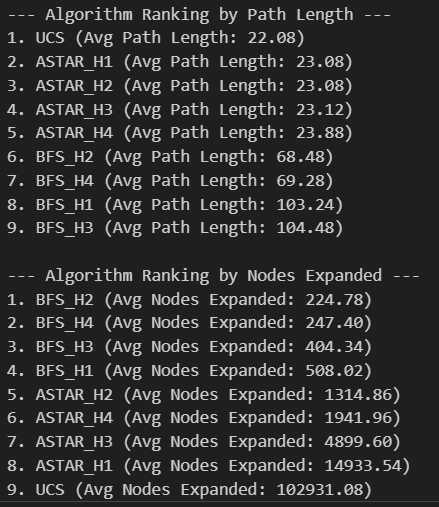

AVERAGE DETAILED RESULTS FOR EACH ALGORITHM :

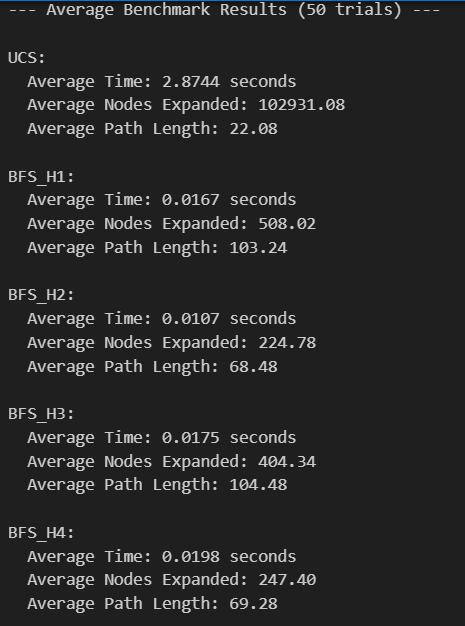 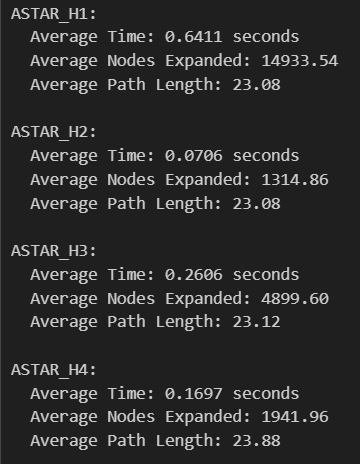

ANSWERS TO QUESTIONS: 

D) BFS implementation using the H2 heuristics outperforms the BFS using H1. It is faster , explores less nodes and the path length is lower. 

E) An admissible heuristic is one that never overestimates the actual cost of reaching the goal.It always provides an estimate that is either equal to or less than the true minimum cost to solve the puzzle from any given state.

H3 heuristic:
Row mismatch: Counts the number of tiles that are not in their correct row.

Column mismatch: Counts the number of tiles that are not in their correct column.

We can take a counter example to show that H3 is not optimal: 

EXAMPLE STATE :

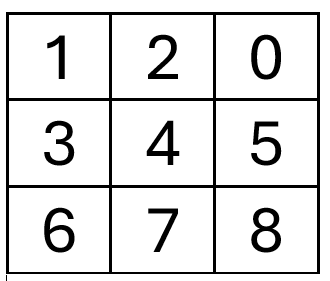

GOAL STATE : 

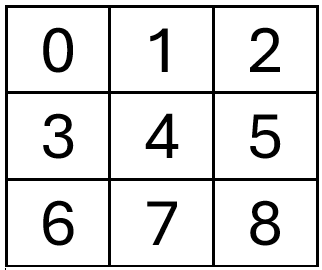


The H3 heuristic will output 3 for the example state as the 0 is in the wrong column 1 and 2 also. However the true cost is 2 as we just have to switch 0 and 2 , then 2 and 0.

H3 using BFS is very similar in terms of performance to BFS H1. However it is less efficient than BFS H2. 

F) A* using heuristics 2 also outperforms A* using H1 . It is also way faster, explores 10x less nodes and find the best solution. 

In my opinion the second heuristic is better because of the 'entropy' measure of the grid. The manhattan is giving a good idea of how mixed the grid is and is being able to converge rapidly to cycling patterns for the blank tile. 

G) The UCS is better in terms of optimality as it behaves like a Breadth First Search. However if we are looking for speed and memory efficiency we should choose A*. It explores less nodes and founds a solution way faster. It is also quite close in terms of path length. 

BONUSES :

-random initial state generator. 

-function to check if initial state is solvable.(in case a user give an impossible grid configuration)

-New heuristic (manhattan distance + linear conflict)


We can see through the precedent benchmark that the fourth heuristic that i choose to implement is not outperforming the manhattan distance heuristic. 
At first glance I thought it would be the case as we add some information about the linear conflict but in the end it does not help to find the best solution. 

It stills outperforms H1 and H3 as the manhattan distance is included in it...